In [1]:
import sys
import numpy as np
import rescomp as rc
import networkx as nx
from scipy import sparse
import matplotlib.pyplot as plt
import sklearn.gaussian_process as GP
from scipy.interpolate import CubicSpline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot2d(t, U, color=None, title=''):
    if color is None:
        color = np.random.rand(U.shape[1], 3)
    for i, c in enumerate(color):
        plt.plot(t, U[:, i], c=c)
    plt.title(title)
    plt.show()
    return color

In [3]:
def valid_prediction_index(err, tol):
    """First index i where err[i] > tol. err is assumed to be 1D and tol is a float. If err is never greater than tol, then len(err) is returned."""
    mask = np.logical_or(err > tol, ~np.isfinite(err))
    if np.any(mask):
        return np.argmax(mask)
    return len(err)

def wa_vptime(ts, Uts, pre, vpttol=0.5):
    """
    Valid prediction time for a specific instance.
    """
    err = np.linalg.norm(Uts-pre, axis=1, ord=2)
    idx = valid_prediction_index(err, vpttol)
    if idx == 0:
        vptime = 0.
    else:
        vptime = ts[idx-1] - ts[0]

    return vptime

In [4]:
# GET TRAINING AND TESTING SIGNALS
t, U = rc.orbit('lorenz', duration=1000)
u = CubicSpline(t, U)
tr = t[:4000]
Utr = u(t[:4000])
ts = t[4000:]
Uts = u(t[4000:])

In [5]:
def div(res_signal):
    combo = 124750 # 500 choose 2
    n = 500

    abs_div = np.sum([np.abs(np.abs(res_signal)[i]-np.abs(res_signal)) for i in range(n)])*(tr[1]-tr[0])
    abs_div /= combo
    abs_div /= tr[-1]

    # diversity between derivatives
    der_div = np.sum(np.abs([np.gradient(res_signal[i])-np.gradient(res_signal)[1] for i in range(n)]))*(tr[1]-tr[0])
    der_div /= combo
    der_div /= tr[-1]

    return abs_div, der_div

In [6]:
def testit(rho, pthin, a, g, s, norm=True):

    # OTHER PARAMS
    n = 500
    c = 4

    # CREATE GRAPH
    A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
    A = sparse.dok_matrix(nx.adj_matrix(A).T)

    # MAKE RESERVOIR
    if norm:
        # B = A*(rho/np.max(np.abs(sparse.linalg.eigs(A.astype(float))[0])))
        B = A*(rho/np.abs(sparse.linalg.eigs(A.astype(float),k=1)[0][0]))
        res = rc.ResComp(B.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    else:
        res = rc.ResComp(A.tocoo().astype(float), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    res.train(tr, Utr)
                
    # GET VPT
    Upred, _ = res.predict(ts, r0=res.r0, return_states=True)

    #  RES_CONDITION
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0=r0)

    # VPT
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    return Upred, vpt, res_states

In [7]:
def testit(rho, pthin, a, g, s, norm=True):

    # OTHER PARAMS
    n = 500
    c = 4

    # CREATE GRAPH
    A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
    A = sparse.dok_matrix(nx.adj_matrix(A).T)

    # MAKE RESERVOIR
    B = A*(rho/np.abs(sparse.linalg.eigs(A.astype(float),k=1)[0][0]))
    res = rc.ResComp(B.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
    res.train(tr, Utr)
                
    # GET VPT
    r0 = res.initial_condition(Utr[0])
    Upred, _ = res.predict(ts, return_states=True)

    #  RES_CONDITION
    r0 = res.initial_condition(Utr[0])
    res_states = res.internal_state_response(tr, Utr, r0=r0)

    # VPT
    vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)

    return r0, Upred, vpt, res_states

In [8]:
rho = 50
pthin = 0.8
my_pred_50_80, my_vpt_50_80, res_states_50_80 = testit(rho, pthin, 0.0001, 5, 0.05, norm=True)
plot2d(t[:2000], res_states_50_80[:2000], title=f'rho={rho}, pthin={pthin}\nvpt={np.round(my_vpt_50_80,4)}');
print(my_vpt_50_80)

ValueError: too many values to unpack (expected 3)

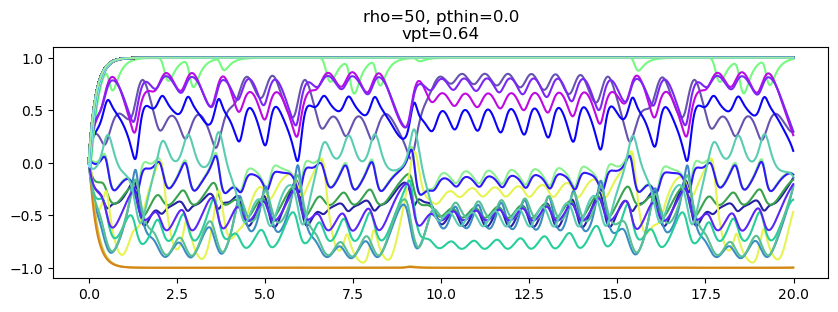

0.6400000000000006
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

In [ ]:
rho = 50
pthin = 0.
r0, my_pred_50_0, my_vpt_50_0, res_states_50_0 = testit(rho, pthin, 0.0001, 5, 0.05, norm=True)
plot2d(t[:2000], res_states_50_0[:2000], title=f'rho={rho}, pthin={pthin}\nvpt={np.round(my_vpt_50_0,4)}');
print(my_vpt_50_0)
print(r0)

Text(0.5, 0.98, '')

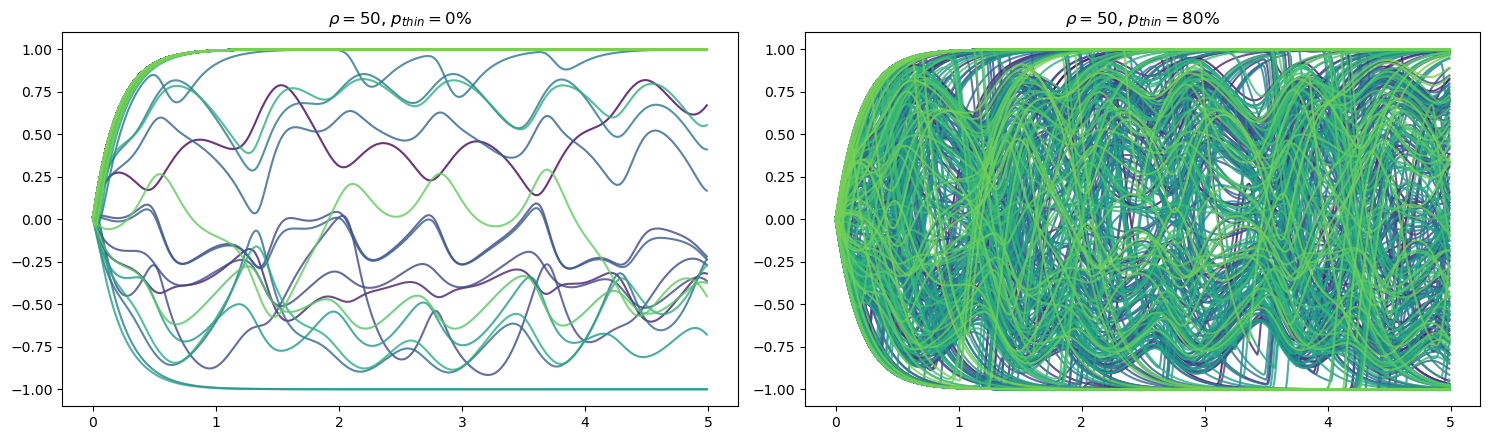

In [ ]:
plt.rcParams["figure.figsize"] = (15,4.5)

fig, (ax1, ax2) = plt.subplots(1,2)

for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,500))):
    ax1.plot(t[:500], res_states_50_0[:500, [i]], '-', color=c, alpha=0.8)
ax1.set_ylim(-1.1,1.1)
ax1.set_title(r'$\rho=50$, $p_{thin}=0\%$')


order2 = np.argsort(res_states_50_80[0])
for i,c in enumerate(plt.get_cmap('viridis')(np.linspace(0,0.8,500))):
    ax2.plot(t[:500], res_states_50_80[:500, order2[i]], '-', color=c, alpha=0.8)
ax2.set_ylim(-1.1,1.1)
ax2.set_title(r'$\rho=50$, $p_{thin}=80\%$')

plt.tight_layout()
fig.suptitle('')

In [47]:
def div2(res_signal):
    combo = 124750 # 500 choose 2
    n = 500

    abs_div = np.sum([np.abs(np.abs(res_signal)[i]-np.abs(res_signal)) for i in range(n)])*(tr[1]-tr[0])
    abs_div /= combo
    abs_div /= (tr[-1]*2)

    return abs_div

In [48]:
def div1(res_signal):
    combo = 124750 # 500 choose 2
    n = 500
    
    # diversity between derivatives
    der_div = np.sum(np.abs([np.gradient(res_signal[i])-np.gradient(res_signal)[1] for i in range(n)]))*(tr[1]-tr[0])
    der_div /= combo
    der_div /= tr[-1]

    return der_div    

In [49]:
div1(res_states_50_0)

0.014248119054392182

In [50]:
div1(res_states_50_80)

0.3489639641628043

In [51]:
div2(res_states_50_0)

0.0499117539940464

In [52]:
div2(res_states_50_0)

0.14714357342263507

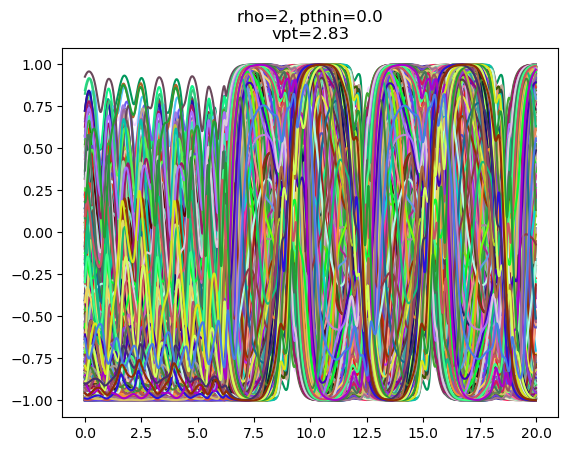

2.8299999999999983


In [ ]:
rho = 2
pthin = 0.
my_pred_2_0, my_vpt_2_0, res_states_2_0 = testit(rho, pthin, 0.0001, 5, 0.05, norm=True)
plot2d(t[:2000], res_states_2_0[:2000], title=f'rho={rho}, pthin={pthin}\nvpt={np.round(my_vpt_2_0,4)}');
print(my_vpt_2_0)

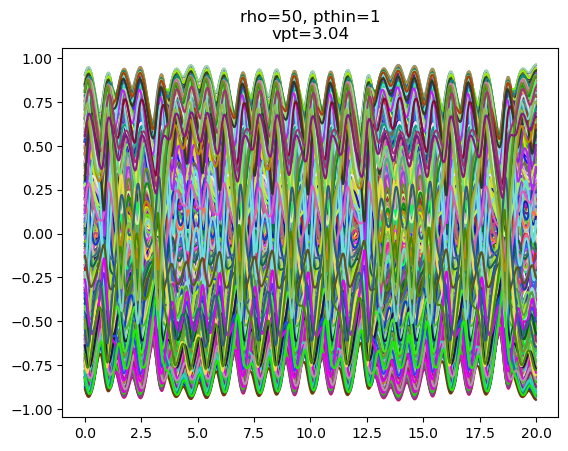

3.039999999999999


In [ ]:
rho = 50
pthin = 1
my_pred_50_1, my_vpt_50_1, res_states_50_1 = testit(rho, pthin, 0.0001, 5, 0.05, norm=True)
plot2d(t[:2000], res_states_50_1[:2000], title=f'rho={rho}, pthin={pthin}\nvpt={np.round(my_vpt_50_1,4)}');
print(my_vpt_50_1)

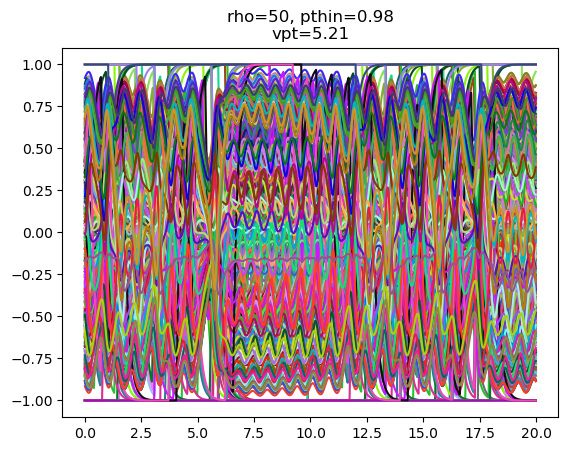

5.210000000000001


In [ ]:
rho = 50
pthin = 0.98
my_pred_50_98, my_vpt_50_98, res_states_50_98 = testit(rho, pthin, 0.0001, 5, 0.05, norm=True)
plot2d(t[:2000], res_states_50_98[:2000], title=f'rho={rho}, pthin={pthin}\nvpt={np.round(my_vpt_50_98,4)}');
print(my_vpt_50_98)

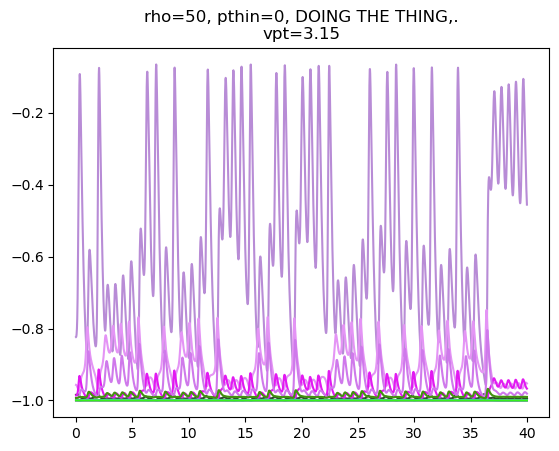

3.1499999999999986


In [ ]:
# ICK
my_vpt, res_states = testit(50, 0., 0.0001, 5, 0.05, norm=False)
plot2d(t[:4000], res_states[:4000,:10], title=f'rho=50, pthin=0, DOING THE THING,.\nvpt={np.round(my_vpt,4)}');
print(my_vpt)

In [1]:
# KERNEL: nu=2.5, lengthscale=3.0, alpha=0.001 - BEST VPT 1.4846000000000024
my_vpt, res_states = testit(50, 0., 0.6161465103541804, 31.940837228064776, 0.335835658873506, norm=False)
plot2d(t[:4000], res_states[:4000, :10], title=f'rho=50. pthin=0, okayish BHO\nvpt={np.round(my_vpt,4)}');
print(my_vpt)

rc.plot2d(t[:4000], res_states[:4000, :10]);
rc.plot2d(t[:4000], res_states[:4000, 10:20]);
rc.plot2d(t[:4000], res_states[:4000, 30:45]);
rc.plot2d(t[:4000], res_states[:4000, 45:60]);
rc.plot2d(t[:4000], res_states[:4000, 60:75]);
rc.plot2d(t[:4000], res_states[:4000, 75:90]);

NameError: name 'testit' is not defined

In [33]:
# OTHER PARAMS
n = 500
c = 4
pthin = 0.98
rho = 50
s = 0.05
g = 5
a = 0.001

# CREATE GRAPH
A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
A = sparse.dok_matrix(nx.adj_matrix(A).T)

# MAKE RESERVOIR
res = rc.ResComp(A.tocoo().astype(float), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
# res.scale_spect_rad()
res.train(tr, Utr)
            
# GET VPT
Upred, _ = res.predict(ts, r0=res.r0, return_states=True)
vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)
res_states = res.internal_state_response(t, u(t), res.initial_condition(Utr[0]))
vpt

7.550000000000004

In [34]:
B = A*(rho/np.max(np.abs(sparse.linalg.eigs(A.astype(float))[0])))
res = rc.ResComp(B.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
res.train(tr, Utr)
            
# GET VPT
Upred, _ = res.predict(ts, r0=res.r0, return_states=True)
vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)
res_states = res.internal_state_response(t, u(t), res.initial_condition(Utr[0]))
vpt

3.219999999999999

In [ ]:
# OTHER PARAMS
n = 500
c = 4
pthin = 0.0
rho = 50
s = 0.05
g = 5
a = 0.001

# CREATE GRAPH
A = nx.erdos_renyi_graph(n,c*(1-pthin)/(n-1),directed=True)
A = sparse.dok_matrix(nx.adj_matrix(A).T)

# MAKE RESERVOIR
res = rc.ResComp(A.tocoo().astype(float), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
# res.scale_spect_rad()
res.train(tr, Utr)
            
# GET VPT
Upred, _ = res.predict(ts, r0=res.r0, return_states=True)
vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)
res_states = res.internal_state_response(t, u(t), res.initial_condition(Utr[0]))
vpt

4.420000000000002

In [ ]:
B = A*(rho/np.max(np.abs(sparse.linalg.eigs(A.astype(float))[0])))
res = rc.ResComp(B.tocoo(), spect_rad=rho, sigma=s, gamma=g, ridge_alpha=a)
res.train(tr, Utr)
            
# GET VPT
Upred, _ = res.predict(ts, r0=res.r0, return_states=True)
vpt = wa_vptime(ts[:-2], Uts[:-2], Upred[2:], vpttol=5)
res_states = res.internal_state_response(t, u(t), res.initial_condition(Utr[0]))
vpt

0.8900000000000006